In [41]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [42]:
bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/h_inf_bag_after_circle_trim.bag')

position_optitrack = []
desired_position = []
vel_optitrack = []
desired_vel = []
control_input = []

for topic, msg, t in bag.read_messages(topics=['position_Optitrack', 'vel_Optitrack', 'desired_position', 'desired_vel', 'control_input']):
    
    if topic == 'position_Optitrack':
        position_optitrack.append((msg.x, msg.y, msg.z))
        
    if topic == 'vel_Optitrack':
        vel_optitrack.append((msg.x, msg.y, msg.z))
        
    if topic == 'desired_position':
        desired_position.append((msg.x, msg.y, msg.z))
        
    if topic == 'desired_vel':
        desired_vel.append((msg.x, msg.y, msg.z))
    
    if topic == 'control_input':
        control_input.append((msg.x, msg.y, msg.z))
bag.close()

position_optitrack = np.array(position_optitrack)
vel_optitrack = np.array(vel_optitrack)
desired_position = np.array(desired_position)
desired_vel = np.array(desired_vel)
control_input = np.array(control_input)

In [43]:
time = []
initial_time = 0
Ts = 1/30

for i in range(len(position_optitrack)):
    time.append(initial_time)
    initial_time+=Ts

# X accel vs angle

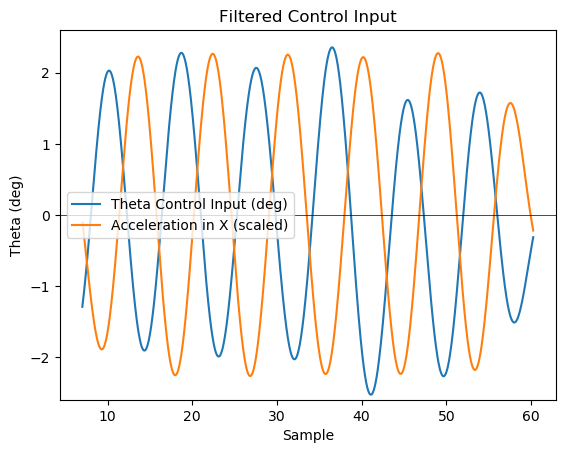

In [44]:
############### Finding the Acceleration ##################
# Filter parameters
N = 5  # Filter order
Wn = 0.01  # Cutoff frequency (as a fraction of the Nyquist frequency)
b, a = butter(N, Wn, 'low')

# Filter the velocity
vel_optitrack_ = np.array(vel_optitrack)[:, 0]
filtered_velocity = filtfilt(b, a, vel_optitrack_.squeeze())

# Numerical differentiation to find acceleration
dt = np.diff(time)  # Time intervals
acceleration = np.diff(filtered_velocity) / dt  # Numerical derivative


############## Filtering the Control Input ###############
control_input_ = np.array(control_input)[:, 0]
# Apply the filter
filtered_control_input = filtfilt(b, a, control_input_.squeeze())

# Convert to degrees
filtered_control_input_deg = np.rad2deg(filtered_control_input)

# Plotting
max_t = 18
min_t = 7
plt.plot(time[min_t*30:-max_t*30], filtered_control_input_deg[min_t*30:-max_t*30], label='Theta Control Input (deg)')
plt.plot(time[(1+min_t*30):-max_t*30], [x*5 for x in acceleration[min_t*30:-max_t*30]], label='Acceleration in X (scaled)')

plt.axhline(y=0, color='k', linewidth=0.5)
plt.ylim(-2.6, 2.6)
plt.xlabel('Sample')
plt.ylabel('Theta (deg)')
plt.title('Filtered Control Input')
plt.legend()
plt.show()

In [45]:
np.mean(filtered_control_input_deg[min_t*30:-max_t*30])

-0.040919920039939696

# Y accel vs angle

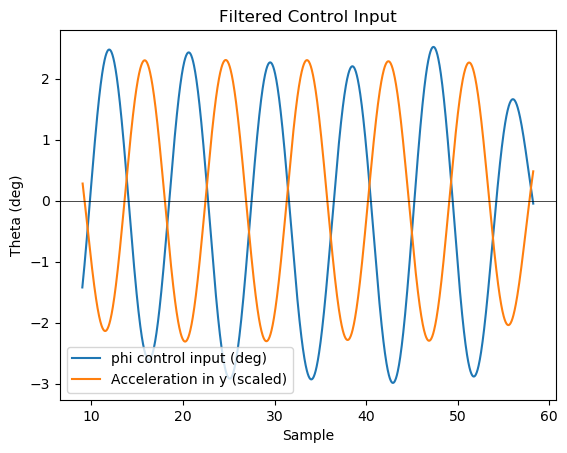

In [46]:
############### Finding the Acceleration ##################
# Filter parameters
N = 5  # Filter order
Wn = 0.01  # Cutoff frequency (as a fraction of the Nyquist frequency)
b, a = butter(N, Wn, 'low')

# Filter the velocity
vel_optitrack_ = np.array(vel_optitrack)[:, 1]
filtered_velocity = filtfilt(b, a, vel_optitrack_.squeeze())

# Numerical differentiation to find acceleration
dt = np.diff(time)  # Time intervals
acceleration = np.diff(filtered_velocity) / dt  # Numerical derivative


############## Filtering the Control Input ###############
control_input_ = np.array(control_input)[:, 1]
# Apply the filter
filtered_control_input = filtfilt(b, a, control_input_.squeeze())

# Convert to degrees
filtered_control_input_deg = np.rad2deg(filtered_control_input)

# Plotting
max_t = 20
min_t = 9

plt.plot(time[min_t*30:-max_t*30], filtered_control_input_deg[min_t*30:-max_t*30], label='phi control input (deg)')
plt.plot(time[(1+min_t*30):-max_t*30], [x*5 for x in acceleration[min_t*30:-max_t*30]], label='Acceleration in y (scaled)')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('Sample')
plt.ylabel('Theta (deg)')
plt.title('Filtered Control Input')
plt.legend()
plt.show()

In [47]:
np.mean(filtered_control_input_deg[10*30:-10*30])

-0.14622677548351967

# X

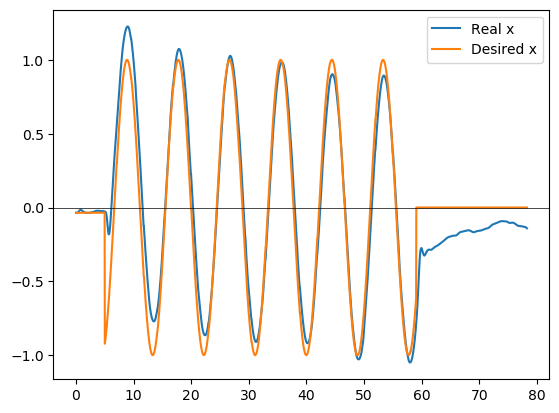

In [48]:
plt.plot(time, [x[0] for x in position_optitrack], label='Real x')
plt.plot(time, [x[0] for x in desired_position], label='Desired x')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.legend()
plt.show()

### X RMSE - Taking off the positioning task

In [49]:
x_square_error = (desired_position[6*30:-20*30, 1] - position_optitrack[6*30:-20*30, 1])**2
x_mse = np.sqrt(np.mean(x_square_error))
x_mse

0.15145306966952635

# Y

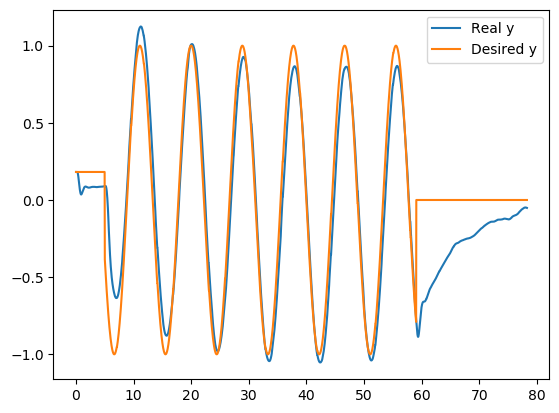

In [50]:
# Plotting example
plt.plot(time, [x[1] for x in position_optitrack], label='Real y')
plt.plot(time, [x[1] for x in desired_position], label='Desired y')

# Adding a horizontal line
#zplt.axhline(y=10, color='r', linewidth=0.5)
# plt.scatter(range(len(position_gaussian_error)), [x[2] for x in position_gaussian_error], label='position_gaussian_error z', s=0.7)
# Add more plots as needed
# plt.ylim(0.92, 1.02)
plt.legend()
plt.show()

### Y MSE - Taking off the positioning task

In [51]:
y_square_error = (desired_position[10*30:-20*30, 1] - position_optitrack[10*30:-20*30, 1])**2
y_mse = np.sqrt(np.mean(y_square_error))
y_mse

0.139761953289191

# Control Effort

## Theta

In [52]:
def control_effort(u):
    effort = 0
    for i in range(len(u) - 1):
        effort += u[i+1]-u[i]

    return effort

control_effort(np.array(control_input)[:, 0])

-0.031954224984525395

## phi

In [53]:
control_effort(np.array(control_input)[:, 1])

0.02612478006957868

## Thrust

In [54]:
control_effort(np.array(control_input)[:, 2])

0.03719884097512616

# Conclusion

The accuracy of the drone has significantly improved just by adjusting the trim angles. Given the drone's small size, the markers have a substantial impact on its stability.

Regarding the error metrics, the H infinity control demonstrated excellent performance, exhibiting the smallest error among all the controllers during trajectory tracking. However, it should be noted that this controller takes a considerable amount of time to reach the desired position.

It's important to note that the H infinity controller was unable to effectively control the drone's z-axis positioning. Consequently, a Proportional-Derivative (PD) controller was implemented specifically to manage this aspect.